In [1]:
# Importing open-source libraries

# AWS Client Data Libraries
import boto3
from botocore import UNSIGNED
from botocore.client import Config
from numba import jit
import numba

# Standard Libaries
import os
from pathlib import Path
import soundfile as sf
import json
import datetime
from datetime import datetime, timedelta
from IPython.display import Audio
from tqdm.notebook import trange, tqdm

# Statistics / Analsyis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.patches import Rectangle
import scipy
import pandas as pd
import cv2
import librosa
from scipy.signal import find_peaks
import sklearn
from scipy.ndimage import convolve
import scipy

from tensorflow.keras.optimizers import Adam
from keras.layers import Dense
from keras import Model
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16

C:\ProgramData\Anaconda3\envs\oceansoundscape2\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\ProgramData\Anaconda3\envs\oceansoundscape2\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
C:\ProgramData\Anaconda3\envs\oceansoundscape2\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
def get_iou(bb1, bb2):
    assert bb1['x1'] < bb1['x2']
    assert bb1['y1'] < bb1['y2']
    assert bb2['x1'] < bb2['x2']
    assert bb2['y1'] < bb2['y2']
    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])
    if x_right < x_left or y_bottom < y_top:
        return 0.0
    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou


cv2.setUseOptimized(True);
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()


train_images = []
train_labels = []

POSITIVE_PATH = r'C:\Users\vikas\OneDrive\Artash_Python\2023 Test\2 - Unk Detection\Dataset\RCNN Data\Positive'
NEGATIVE_PATH = r'C:\Users\vikas\OneDrive\Artash_Python\2023 Test\2 - Unk Detection\Dataset\RCNN Data\Negative'

for im_path in tqdm(os.listdir(POSITIVE_PATH)):
    im = plt.imread(os.path.join(POSITIVE_PATH, im_path))
    train_images.append(im[:, :, :3])
    train_labels.append(1)
    
for im_path in tqdm(os.listdir(NEGATIVE_PATH)):
    im = plt.imread(os.path.join(NEGATIVE_PATH, im_path))
    train_images.append(im[:, :, :3])
    train_labels.append(0)

  0%|          | 0/5521 [00:00<?, ?it/s]

  0%|          | 0/10632 [00:00<?, ?it/s]

In [4]:
train_labels = np.array(train_labels)
train_images = np.array(train_images)

print("Augmented Data for RCNN:")
print("Positive Detection Samples: {}".format(np.sum(np.array(train_labels) == 1)))
print("Negative Detection Samples: {}".format(np.sum(np.array(train_labels) == 0)))

Augmented Data for RCNN:
Positive Detection Samples: 5521
Negative Detection Samples: 10632


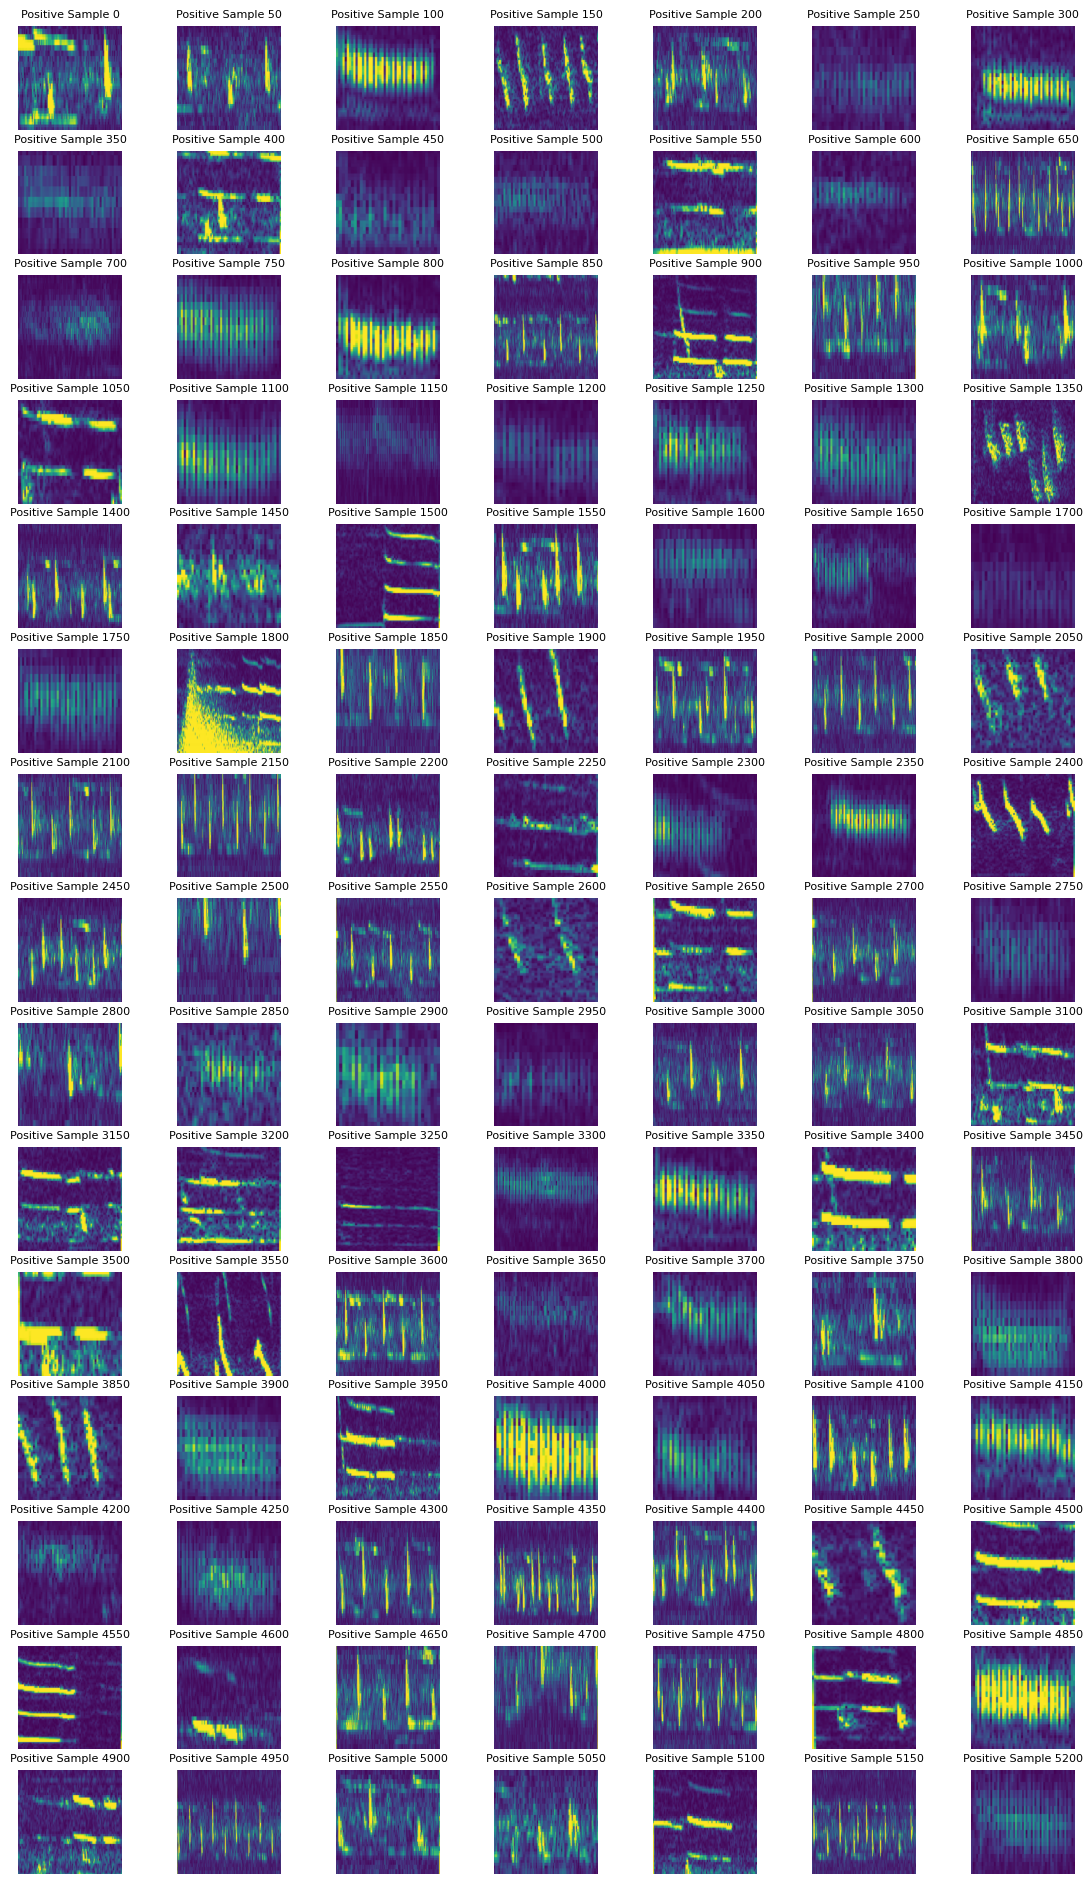

In [5]:
plt.figure(figsize=(14,24))
plt.rcParams['axes.titlelocation'] = 'center'
count = 0
for i, im in enumerate(np.array([train_images[i] for i, x in enumerate(train_labels) if x == 1])):
    if count < 105:
        if i%50 == 0:
            plt.subplot(15, 7, count + 1)
            plt.imshow(im)
            plt.axis('off')
            plt.title("Positive Sample {}".format(i), fontsize=8)
            count+=1

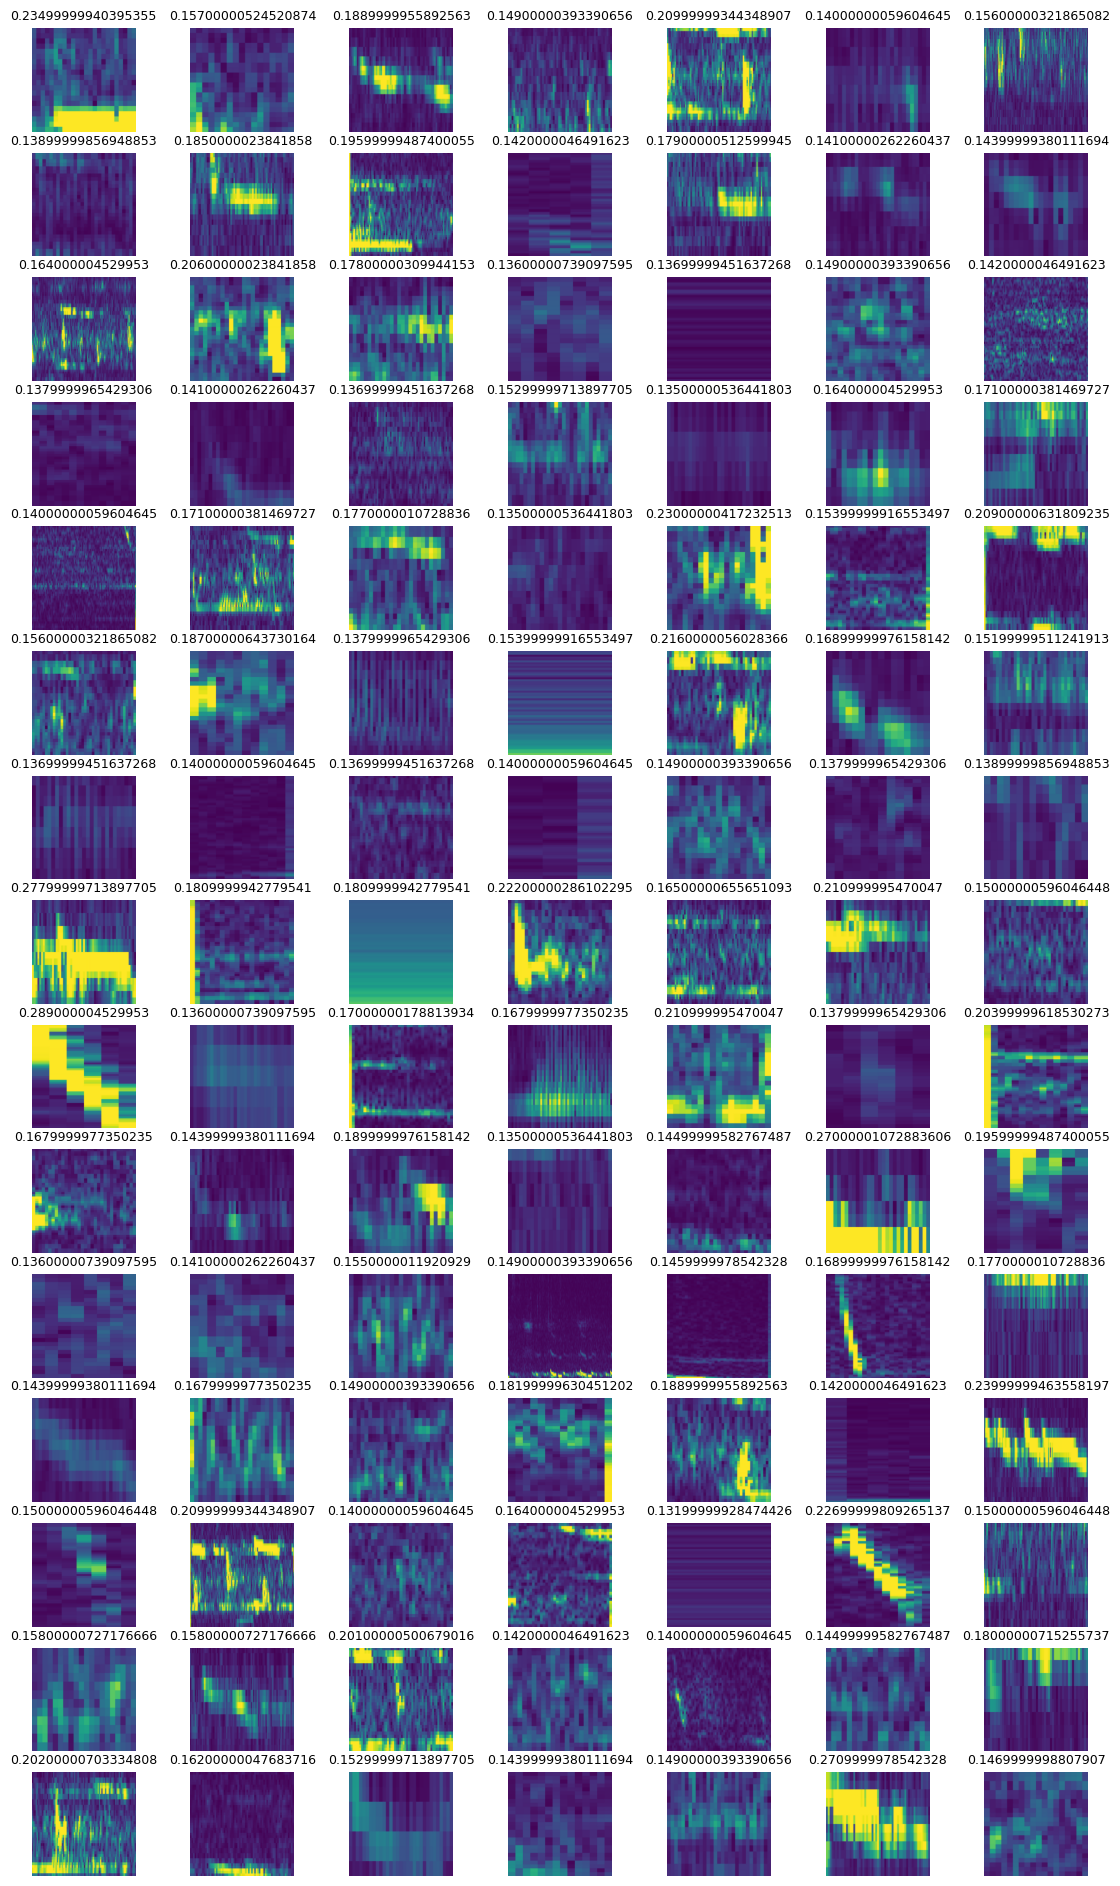

In [6]:
plt.figure(figsize=(14,24))
plt.rcParams['axes.titlelocation'] = 'center'
count = 0
for i, im in enumerate(np.array([train_images[i] for i, x in enumerate(train_labels) if x == 0])):
    if count < 105:
        if i%100 == 0:
            plt.subplot(15, 7, count + 1)
            plt.imshow(im)
            plt.axis('off')
            plt.title("{}".format(round(np.std(im), 3)), fontsize=9)
            count+=1

In [2]:
X_new = np.array(train_images)
y_new = np.array(train_labels)

NameError: name 'train_images' is not defined

In [3]:
vggmodel = VGG16(weights='imagenet', include_top=True)
vggmodel.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [4]:
for layers in (vggmodel.layers)[:15]:
    print(layers)
    layers.trainable = False

In [5]:
X= vggmodel.layers[-2].output
predictions = Dense(2, activation="softmax")(X)
opt = Adam(lr=0.0001)

C:\ProgramData\Anaconda3\envs\oceansoundscape2\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [6]:
model_final = Model(inputs = [vggmodel.input], outputs = [predictions])
model_final.compile(loss = tf.keras.losses.categorical_crossentropy, optimizer = opt, metrics=["accuracy"])

In [7]:
model_final.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

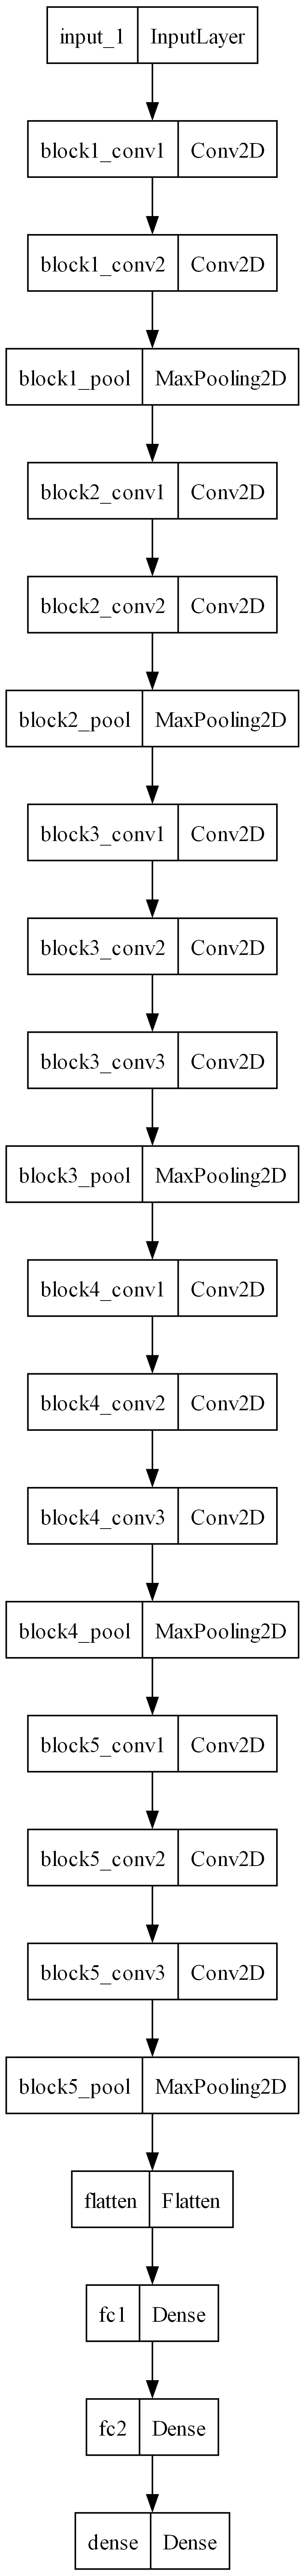

In [9]:
tf.keras.utils.plot_model(model_final, dpi=300)

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

class MyLabelBinarizer(LabelBinarizer):
    def transform(self, y):
        Y = super().transform(y)
        if self.y_type_ == 'binary':
            return np.hstack((Y, 1-Y))
        else:
            return Y
    def inverse_transform(self, Y, threshold=None):
        if self.y_type_ == 'binary':
            return super().inverse_transform(Y[:, 0], threshold)
        else:
            return super().inverse_transform(Y, threshold)
        
lenc = MyLabelBinarizer()
Y =  lenc.fit_transform(y_new)

NameError: name 'y_new' is not defined

In [14]:
X_train, X_test , y_train, y_test = train_test_split(X_new,Y,test_size=0.20)
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(12922, 224, 224, 3) (3231, 224, 224, 3) (12922, 2) (3231, 2)


In [15]:
trdata = ImageDataGenerator(horizontal_flip=False, vertical_flip=False, rotation_range=1)
traindata = trdata.flow(x=X_train, y=y_train, batch_size=32)
tsdata = ImageDataGenerator(horizontal_flip=False, vertical_flip=False, rotation_range=1)
testdata = tsdata.flow(x=X_test, y=y_test)

from keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint("ieeercnn_vgg16_1.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=100, verbose=1, mode='auto')

In [17]:
model_hist = model_final.fit_generator(generator= traindata, steps_per_epoch= 400, epochs= 30, validation_data= testdata, callbacks=[checkpoint,early])

C:\Users\vikas\AppData\Local\Temp\ipykernel_25812\3356329481.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_hist = model_final.fit_generator(generator= traindata, steps_per_epoch= 400, epochs= 30, validation_data= testdata, callbacks=[checkpoint,early])


Epoch 1/30
400/400 [==============================] - ETA: 0s - loss: 0.2241 - accuracy: 0.9333
Epoch 1: val_loss improved from inf to 0.08447, saving model to ieeercnn_vgg16_1.h5
400/400 [==============================] - 117s 291ms/step - loss: 0.2241 - accuracy: 0.9333 - val_loss: 0.0845 - val_accuracy: 0.9681
Epoch 2/30
400/400 [==============================] - ETA: 0s - loss: 0.0830 - accuracy: 0.9697
Epoch 2: val_loss did not improve from 0.08447
400/400 [==============================] - 109s 271ms/step - loss: 0.0830 - accuracy: 0.9697 - val_loss: 0.0874 - val_accuracy: 0.9638
Epoch 3/30
400/400 [==============================] - ETA: 0s - loss: 0.0583 - accuracy: 0.9798
Epoch 3: val_loss did not improve from 0.08447
400/400 [==============================] - 108s 269ms/step - loss: 0.0583 - accuracy: 0.9798 - val_loss: 0.0963 - val_accuracy: 0.9653
Epoch 4/30
400/400 [==============================] - ETA: 0s - loss: 0.0449 - accuracy: 0.9831
Epoch 4: val_loss improved from 0

Exception ignored in: <function UniquePtr.__del__ at 0x000002808777AB80>
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\envs\oceansoundscape2\lib\site-packages\tensorflow\python\framework\c_api_util.py", line 71, in __del__
    obj = self._obj
KeyboardInterrupt: 


KeyboardInterrupt: 

In [9]:
model_final.load_weights("ieeercnn_vgg16_1.h5")

In [10]:
model_final.evaluate(X_test, y_test)

NameError: name 'X_test' is not defined

In [18]:
# plt.plot(hist.history["acc"])
# plt.plot(hist.history['val_acc'])
plt.plot(model_hist.history['loss'])
plt.plot(model_hist.history['val_loss'])
plt.title("model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Loss","Validation Loss"])
plt.show()
plt.savefig('chart loss.png')

NameError: name 'model_hist' is not defined

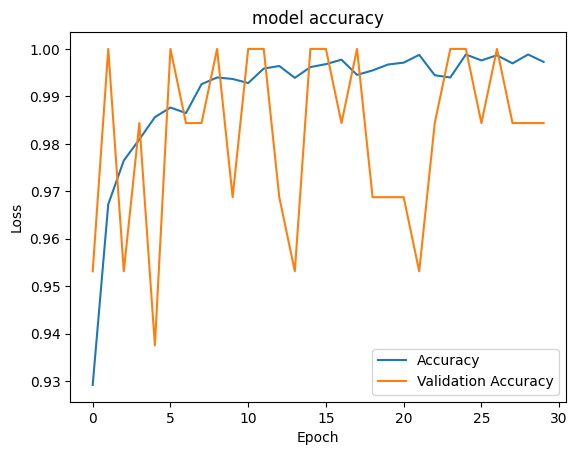

<Figure size 640x480 with 0 Axes>

In [22]:
plt.plot(model_hist.history["accuracy"])
plt.plot(model_hist.history['val_accuracy'])
plt.title("model accuracy")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy"])
plt.show()
plt.savefig('chart loss.png')

In [11]:
plt.figure(figsize=(14,14))
plt.rcParams['axes.titlelocation'] = 'center'
count = 0
for i, im in enumerate(X_test):
    if count < 49:
            plt.subplot(7, 7, count + 1)
            plt.imshow(im)
            img = np.expand_dims(im, axis=0)
            out= model_final.predict(img, verbose=0)
            plt.axis('off')
            if out[0][0] > out[0][1]:
                plt.title("Positive Detection",fontsize=9)
            else:
                plt.title("Negative Detection",fontsize=9)
            count+=1

NameError: name 'X_test' is not defined

<Figure size 1400x1400 with 0 Axes>

1/1 [==============================] - 0s 24ms/step
[[1.0000000e+00 3.0720194e-08]]
Positive


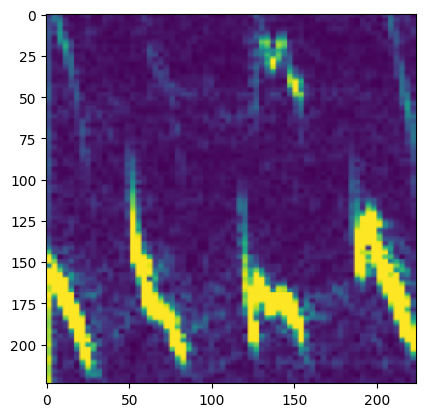

In [27]:
im = X_test[218]
plt.imshow(im)
img = np.expand_dims(im, axis=0)
out= model_final.predict(img)
print(out)
if out[0][0] > out[0][1]:
    print("Positive")
else:
    print("Negatve")

In [31]:
ssresults

array([[468, 120,  72,  63],
       [162, 104,   9,  36],
       [361, 157,  17,  22],
       ...,
       [468, 120,  72,  69],
       [ 14, 128, 178,  55],
       [  0,  60, 204, 123]])

0it [00:00, ?it/s]

Model predicting on 729 images
12/12 [==============================] - 10s 267ms/step
Done


0it [00:00, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


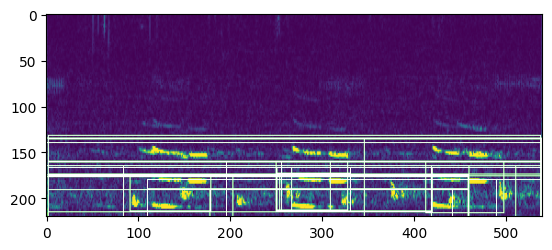

0it [00:00, ?it/s]

Model predicting on 652 images
10/11 [==========================>...] - ETA: 0s

Exception ignored in: <function WeakKeyDictionary.__init__.<locals>.remove at 0x000001A6AAAABE50>
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\envs\oceansoundscape2\lib\weakref.py", line 346, in remove
    self = selfref()
KeyboardInterrupt: 


KeyboardInterrupt: 

In [12]:
path = r'C:\Users\vikas\OneDrive\Artash_Python\2023 Test\2 - Unk Detection\Dataset\20171118'
z=0
for e,i in enumerate(os.listdir(path)[2:]):
        z += 1
        img = plt.imread(os.path.join(path,i))
        ss.setBaseImage(img)
        ss.switchToSelectiveSearchFast()
        ssresults = ss.process()
        imout = img.copy()
        imout_orig = img.copy()
        IMAGES = []
        for e,result in tqdm(enumerate(ssresults)):
            if e < 2000:
                x,y,w,h = result
                timage = imout_orig[y:y+h,x:x+w]
                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)[:, :, :3]
                IMAGES.append(resized)
        print("Model predicting on {} images".format(len(IMAGES)))
        model_predictions = model_final.predict(np.array(IMAGES), batch_size=64)
        print("Done")
        for e, result in tqdm(enumerate(ssresults)):
            if e < 2000:
                x,y,w,h = result
                img = IMAGES[e]
                out = model_predictions[e]
                if out[0] > 0.9:
                    cv2.rectangle(imout, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)

        plt.imshow(imout)
        plt.show()

In [123]:
def area(box):
    # Calculate the area of the bounding box
    return (box[2] - box[0]) * (box[3] - box[1])

def nms(roi_list, iou_threshold=0.5, confidence_threshold=0.5, min_area=None, max_area=None):
    # Apply non-maximum suppression to the list of ROIs
    nms_roi_list = []

    # Split long boxes
    #split_roi_list = []
    #for roi in roi_list:
    #    split_roi_list.extend(split_long_boxes(roi, max_length=100))
    split_roi_list = roi_list
    #Sort ROIs by confidence score (assuming each ROI is in the format [x1, y1, x2, y2, confidence])
    split_roi_list.sort(key=lambda x: (x[4], reverse=True)

    while len(split_roi_list) > 0:
        selected_roi = split_roi_list.pop(0)
        nms_roi_list.append(selected_roi)

        # Calculate IOU (Intersection over Union) with other ROIs
        iou_scores = [overlap_area(selected_roi, roi) / (selected_roi[2] - selected_roi[0]) *
                      (selected_roi[3] - selected_roi[1]) for roi in split_roi_list]

        # Remove ROIs that have high IOU with the selected ROI
        split_roi_list = [roi for i, roi in enumerate(split_roi_list) if iou_scores[i] < iou_threshold]

    # Filter ROIs based on confidence threshold and optional min_area and max_area
    nms_roi_list = [roi for roi in nms_roi_list if roi[4] >= confidence_threshold and
                    (min_area is None or area(roi) >= min_area) and
                    (max_area is None or area(roi) <= max_area)]

    return nms_roi_list


def overlap_area(box1, box2):
    # Calculate the overlap area between two bounding boxes
    x_overlap = max(0, min(box1[2], box2[2]) - max(box1[0], box2[0]))
    y_overlap = max(0, min(box1[3], box2[3]) - max(box1[1], box2[1]))
    return x_overlap * y_overlap


def split_long_boxes(bboxes):
    # Function to split long bounding boxes into multiple boxes of length 100
    new_bboxes = []
    max_length = 100

    for bbox in bboxes:
        x, y, w, h = bbox
        if h > 150:
            continue
        if w > max_length:
            num_splits = w // max_length
            remainder = w % max_length

            for i in range(num_splits):
                new_x = x + i * max_length
                new_w = max_length if i < num_splits - 1 else max_length + remainder
                new_bboxes.append([new_x, y, new_w, h])

        else:
            new_bboxes.append(bbox)

    return np.array(new_bboxes)




def calculate_center(box):
    x, y, w, h = box
    center_x = x + w / 2
    return center_x

def merge_boxes(box1, box2):
    # Merge two boxes by extending their horizontal span
    x = min(box1[0], box2[0])
    y = min(box1[1], box2[1])
    x2 = max(box1[0] + box1[2], box2[0] + box2[2])
    y2 = max(box1[1] + box1[3], box2[1] + box2[3])
    w = x2 - x
    h = y2 - y
    return [x, y, w, h]

def process_bboxes(bboxes, merge_width_threshold=75, vertical_distance_threshold=10, merge_horizontal_threshold=20):
    # Function to process bounding boxes by merging narrow boxes with similar horizontal centers
    new_bboxes = []
    merged_boxes = []

    # Sort bounding boxes by their x-coordinate
    sorted_bboxes = sorted(bboxes, key=lambda box: box[0])

    for i in range(len(sorted_bboxes)):
        x, y, w, h = sorted_bboxes[i]

        if w < merge_width_threshold and i > 0 and abs(y - sorted_bboxes[i - 1][1] - sorted_bboxes[i - 1][3]) < vertical_distance_threshold:
            # Merge narrow boxes with the previous one if they are close along the vertical axis and have close horizontal centers
            prev_center_x = calculate_center(new_bboxes[-1])
            curr_center_x = calculate_center([x, y, w, h])
            if abs(curr_center_x - prev_center_x) < merge_horizontal_threshold:
                # Merge the current box with the previous box
                merged_boxes[-1] = merge_boxes(merged_boxes[-1], [x, y, w, h])
            else:
                new_bboxes.append([x, y, w, h])
                merged_boxes.append([x, y, w, h])
        else:
            new_bboxes.append([x, y, w, h])
            merged_boxes.append([x, y, w, h])

    # Combine original boxes and merged boxes into one list
    combined_boxes = new_bboxes + bboxes + merged_boxes
    combined_boxes = [list(i) for i in list(set(tuple(x) for x in combined_boxes))]

    return combined_boxes

# Combine original boxes and merged boxes into one list
    



SyntaxError: invalid syntax (1311976648.py, line 15)

In [89]:
a = (boundaries+[[1,2,3,4,5]])

In [29]:
len()

960

In [51]:
path = r'C:\Users\vikas\OneDrive\Artash_Python\2023 Test\2 - Unk Detection\Dataset\20171118'
z=0
for e,i in enumerate(os.listdir(path)[2:]):
        z += 1
        img = plt.imread(os.path.join(path,i))
        ss.setBaseImage(img)
        ss.switchToSelectiveSearchFast()
        ssresults = ss.process()
        ssresults = split_long_boxes(ssresults)
        imout = img.copy()
        imout_orig = img.copy()
        IMAGES = []
        for e,result in tqdm(enumerate(ssresults)):
            if e < 2000:
                x,y,w,h = result
                timage = imout_orig[y:y+h,x:x+w]
                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)[:, :, :3]
                IMAGES.append(resized)
        print("Model predicting on {} images".format(len(IMAGES)))
        model_predictions = model_final.predict(np.array(IMAGES))
        print("Done")
        boundaries = []
        for e, result in tqdm(enumerate(ssresults)):
            if e < 2000:
                x,y,w,h = result
                img = IMAGES[e]
                out = model_predictions[e]
                if out[0] > 0.8:
                    boundaries.append([x, y, x+w, y+h, out[0]])
                    #cv2.rectangle(imout, (x1, y1), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
                    #cv2.rectangle(imout, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
        boundaries = nms(boundaries, iou_threshold=0.5, confidence_threshold=0.5, min_area=625, max_area=20000)
        #plt.imshow(imout)
        #plt.show()
        
        for x1, y1, x2, y2, c in boundaries:
            cv2.rectangle(imout_orig, (x1, y1), (x2, y2), (0, 255, 0), 1, cv2.LINE_AA)
        plt.imshow(imout_orig)
        plt.show()

0it [00:00, ?it/s]

Model predicting on 880 images


KeyboardInterrupt: 

In [135]:
def run_model_on_quarters(boxes, image):
    def get_quarter_box_coordinates(box, quarter):
        # Get coordinates of a specific quarter of the box
        x1, y1, x2, y2, c = box
        width = x2 - x1
        height = y2 - y1

        if quarter == 1:
            return [x1, y1, x1 + width // 2, y1 + height // 2]
        elif quarter == 2:
            return [x1 + width // 2, y1, x2, y1 + height // 2]
        elif quarter == 3:
            return [x1, y1 + height // 2, x1 + width // 2, y2]
        elif quarter == 4:
            return [x1 + width // 2, y1 + height // 2, x2, y2]

    def preprocess_image(image, box):
        # Crop the image based on the box coordinates
        cropped_image = image[box[1]:box[3], box[0]:box[2]]
        return cropped_image

    def calculate_mean_pixel_value(image):
        return np.mean(image)

    # Initialize a list to store filtered boxes
    filtered_boxes = []

    for box in boxes:
        # Get the image part for each quarter of the box
        image_parts = [preprocess_image(image, get_quarter_box_coordinates(box, quarter)) for quarter in range(1, 5)]
        
        # Calculate the mean pixel value for each image part
        mean_pixel_values = [calculate_mean_pixel_value(part) for part in image_parts]

        # Check if the mean pixel value of any part is less than 1/5th of the maximum mean pixel value
        if all(mean >= (max(mean_pixel_values) / 5) for mean in mean_pixel_values):
            filtered_boxes.append(box)

    return filtered_boxes

0it [00:00, ?it/s]

Model predicting on 907 images
15/15 [==============================] - 1s 96ms/step
Done


0it [00:00, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1


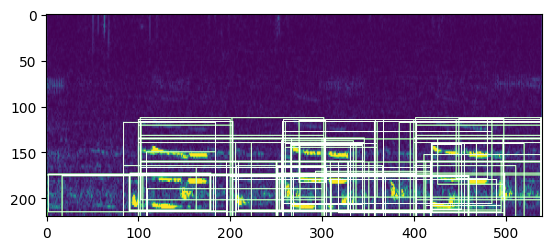

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3


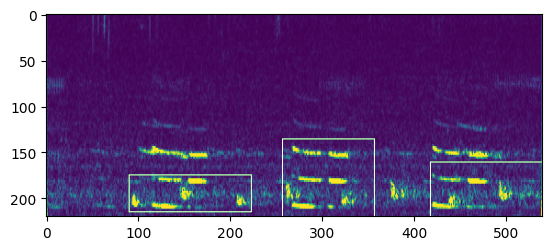

0it [00:00, ?it/s]

Model predicting on 794 images
13/13 [==============================] - 1s 94ms/step
Done


0it [00:00, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1


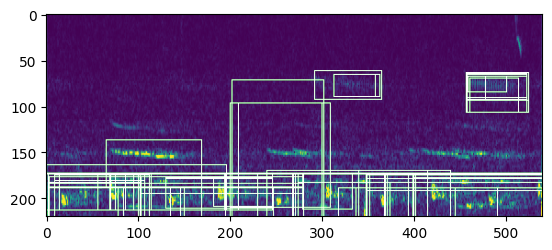

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3


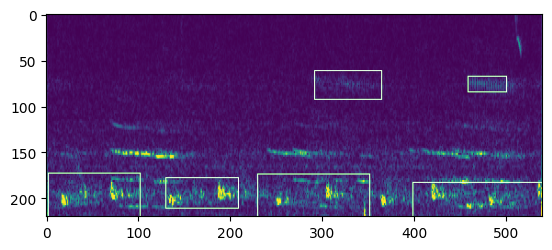

0it [00:00, ?it/s]

Model predicting on 971 images
16/16 [==============================] - 2s 95ms/step
Done


0it [00:00, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1


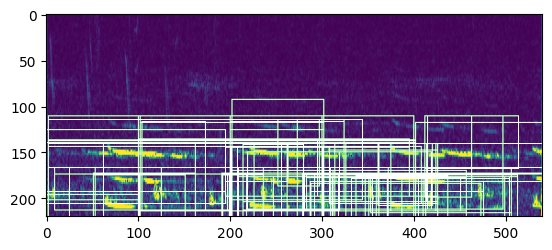

3


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


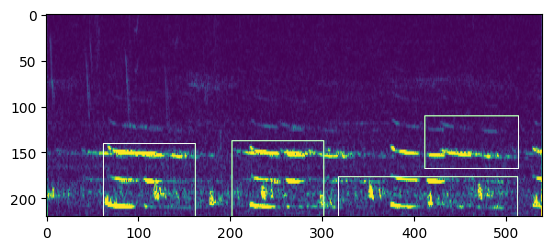

0it [00:00, ?it/s]

Model predicting on 862 images
14/14 [==============================] - 1s 96ms/step
Done


0it [00:00, ?it/s]

1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


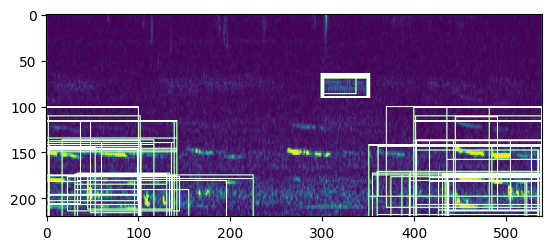

3


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


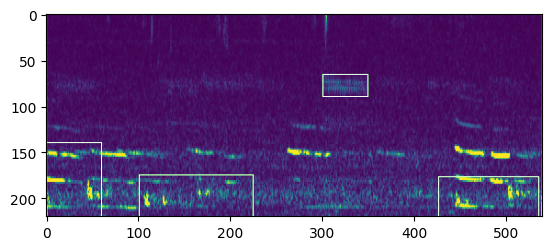

0it [00:00, ?it/s]

Model predicting on 938 images
15/15 [==============================] - 2s 99ms/step
Done


0it [00:00, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1


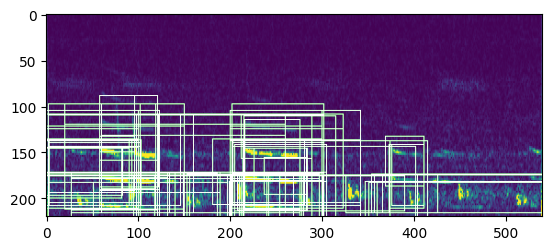

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3


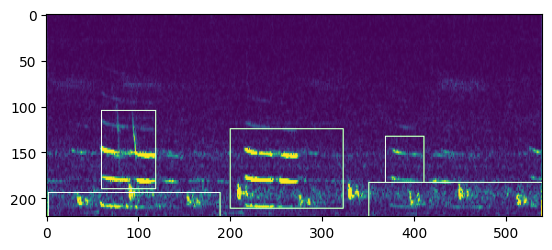

0it [00:00, ?it/s]

Model predicting on 911 images
15/15 [==============================] - 1s 95ms/step
Done


0it [00:00, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1


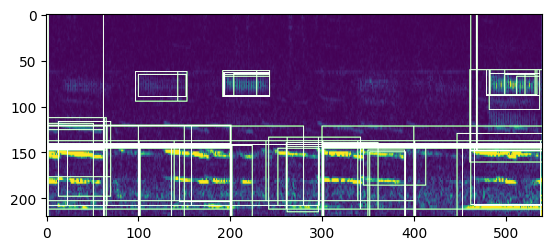

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3


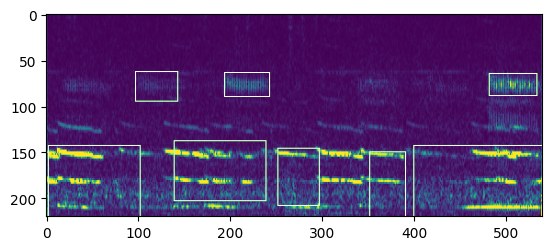

0it [00:00, ?it/s]

Model predicting on 848 images
14/14 [==============================] - 1s 96ms/step
Done


0it [00:00, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1


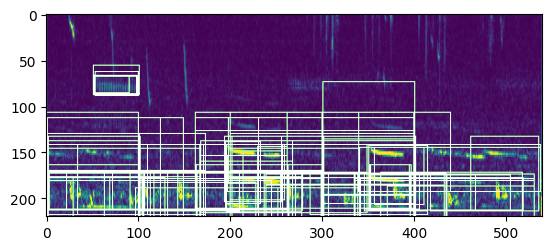

3


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


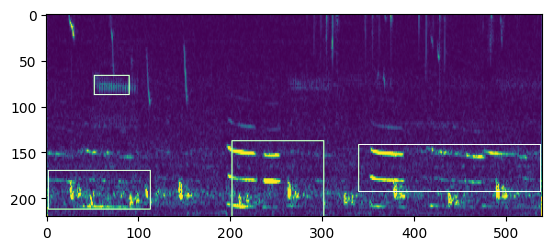

0it [00:00, ?it/s]

Model predicting on 963 images
16/16 [==============================] - 2s 95ms/step
Done


0it [00:00, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1


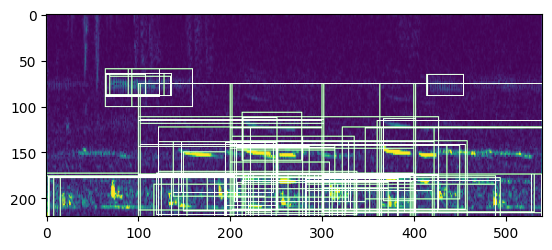

3


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


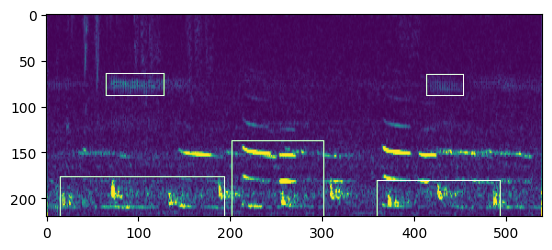

0it [00:00, ?it/s]

Model predicting on 854 images
14/14 [==============================] - 1s 96ms/step
Done


0it [00:00, ?it/s]

1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


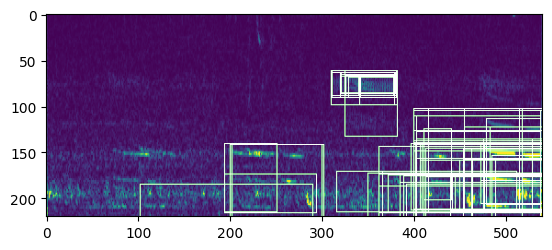

3


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


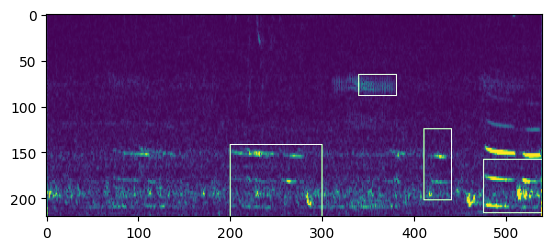

0it [00:00, ?it/s]

Model predicting on 966 images


KeyboardInterrupt: 

In [138]:
path = r'C:\Users\vikas\OneDrive\Artash_Python\2023 Test\2 - Unk Detection\Dataset\20171118'
z=0
for e,i in enumerate(os.listdir(path)[2:]):
        z += 1
        img = plt.imread(os.path.join(path,i))
        ss.setBaseImage(img)
        ss.switchToSelectiveSearchFast()
        ssresults = ss.process()
        ssresults = split_long_boxes(ssresults)
        ssresults = np.array(process_bboxes(list(ssresults),
                                    merge_width_threshold=75, vertical_distance_threshold=50, 
                                    merge_horizontal_threshold=20))
        imout = img.copy()
        imout_orig = img.copy()
        IMAGES = []
        for e,result in tqdm(enumerate(ssresults)):
            if e < 2000:
                x,y,w,h = result
                timage = imout_orig[y:y+h,x:x+w]
                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)[:, :, :3]
                IMAGES.append(resized)
        print("Model predicting on {} images".format(len(IMAGES)))
        model_predictions = model_final.predict(np.array(IMAGES), batch_size=64)
        print("Done")
        boundaries = []
        for e, result in tqdm(enumerate(ssresults)):
            if e < 2000:
                x,y,w,h = result
                img = IMAGES[e]
                out = model_predictions[e]
                if out[0] > 0.6:
                    boundaries.append([x, y, x+w, y+h, out[0]])
                    #cv2.rectangle(imout, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
        
        
        print("1")
        for x1, y1, x2, y2, c in boundaries:
            cv2.rectangle(imout, (x1, y1), (x2, y2), (0, 255, 0), 1, cv2.LINE_AA)
        plt.imshow(imout)
        plt.show()
        
        print("3")
        
        boundaries = nms(boundaries, iou_threshold=0.5, confidence_threshold=0.6,min_area=125, max_area=50000)
        for x1, y1, x2, y2, c in boundaries:
            cv2.rectangle(imout_orig, (x1, y1), (x2, y2), (0, 255, 0), 1, cv2.LINE_AA)
        boundaries = run_model_on_quarters(boundaries, imout)
        plt.imshow(imout_orig)
        plt.show()
        print()
        print()
        print()

In [115]:
0.99**0.5

0.99498743710662